In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis/')
from analog import logextract as logextract

In [3]:
log_path = '/home/lucas/Documents/Log_Analysis/Logs'
log_index = '39'
log_date = '2019-8-27'
log_time = '14-22-40'
log_file = f'{log_path}/log_{log_index}_{log_date}-{log_time}.ulg'
#log_file = f'{log_path}/{log_time}.ulg'
print(log_file)

/home/lucas/Documents/Log_Analysis/Logs/log_39_2019-8-27-14-22-40.ulg


In [4]:
topic_list = ['battery_status']
info = logextract(log_file,topic_list)

In [5]:
time = info['time_bs']
n_cells = info['n_cells']
voltage_v = info['battery_filtered_voltage']
current_a = info['battery_current']
current_filtered_a = info['battery_filtered_current']
_discharged_mah = info['discharged_mah']
_remaining =info['remaining']

In [6]:
# Battery cell parameters
r_internal = 0.005 #Ohm
v_empty = 3.56 #V
v_charged = 4.15 #V
capacity_tot = 6500 #mAh
capacity = capacity_tot - _discharged_mah[0] #mAh

In [7]:
cell_voltage = voltage_v / n_cells
cell_voltage +=  r_internal * current_filtered_a

Text(0, 0.5, 'cell voltage (V)')

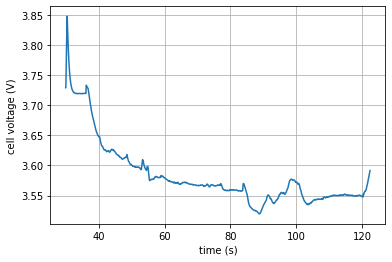

In [8]:
# Figure 1 : unfiltered voltage
plt.figure()
plt.plot(time,cell_voltage)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('cell voltage (V)')

Text(0, 0.5, 'current (A)')

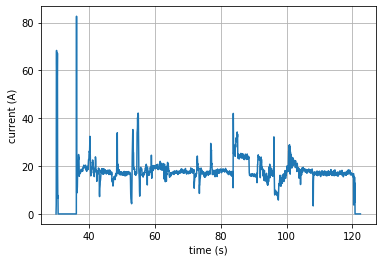

In [9]:
# Figure 2 : unfiltered current
plt.figure()
plt.plot(time,current_a)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('current (A)')

In [10]:
# remaining_voltage is NOT a voltage, it is the remaining percentage based on the voltage
remaining_voltage = (cell_voltage-v_empty)/(v_charged-v_empty)

In [11]:
# coulomb counting
dt = np.diff(time)
discharged_mah_loop = []
discharged_mah_loop.append(0)
for k in range(len(dt)):
    discharged_mah_loop.append(current_a[k+1]*1e3 * dt[k]/3600) # to bring it to mAh
    
discharged_mah = np.cumsum(discharged_mah_loop) + _discharged_mah[0]

In [12]:
current_a[1]*1e3 * (time[1]-time[0])/3600 #mAh

0.06602530063602775

In [13]:
print(_discharged_mah[1])
print(discharged_mah[1])
print(_discharged_mah[-1])
print(discharged_mah[-1])
print(discharged_mah_loop[0])

0.015030736
0.06602530063602775
433.85233
433.6081836642811
0


Text(0, 0.5, 'discharge count (mAh)')

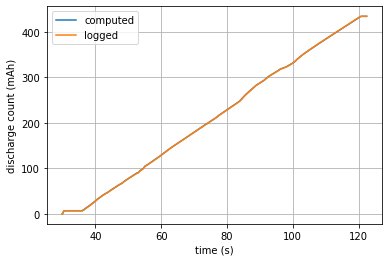

In [14]:
# Figure 3 : Comparation between logged and computed coulomb counting 
plt.figure()
plt.plot(time,discharged_mah,label='computed')
plt.plot(time,_discharged_mah,label='logged')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('discharge count (mAh)')

In [15]:
print(_discharged_mah[0]-discharged_mah[0]) # verification, should be zero

0.0


In [16]:
remaining_current = np.array([_remaining[0]-discharged_mah/capacity_tot]).transpose()

Text(0, 0.5, 'State of Charge (-)')

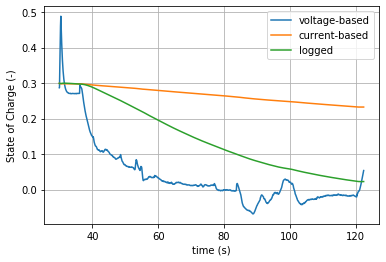

In [17]:
# Figure 4 : remaining charge assuming linear voltage decreasing
plt.figure()
plt.plot(time,remaining_voltage,label='voltage-based')
plt.plot(time,remaining_current,label='current-based')
plt.plot(time,_remaining,label='logged')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

### Now there is a kind of filtering step where the current-based estimation and the voltage-based estimation are balanced
this balance explains the difference between the two curves above

Text(0, 0.5, 'weight')

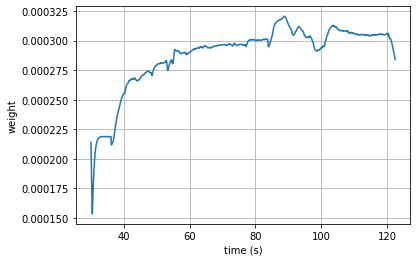

In [18]:
# weight for voltage/current weightning
weight_v = 3e-4 * (1-remaining_voltage)
plt.figure()
plt.plot(time,weight_v)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('weight')

In [19]:
remaining = []
remaining.append(_remaining[0])

# the first discharge_mah_loop is now zero
for k in range(1,len(discharged_mah_loop)): #discharged_mah_loop has one less value than the others
    remaining.append((1-weight_v[k]) * remaining[k-1] + weight_v[k] * remaining_voltage[k])
    remaining[k] -= discharged_mah_loop[k] / capacity_tot
    remaining[k] = np.max(remaining[k],0)

Text(0, 0.5, 'SOC')

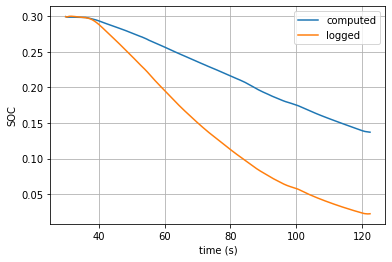

In [20]:
# Figure 5 : remaining SOC
plt.figure()
plt.plot(time,remaining,label='computed')
plt.plot(time,_remaining,label='logged')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('SOC')

# Testing with more accurate SOC = f(OCV) instead of gradual

In [21]:
import math
from scipy.interpolate import interp1d

In [22]:
# LMO assumed because of the empty voltage

a = 3.875
b = -0.335
c = -0.5332
d = 0.8315
m = 0.653
n = 0.6
SOC = np.linspace(0.01,1.4,100)
type(np.log(SOC))

numpy.ndarray

In [23]:
OCVfromSOC = a + b*np.power(-np.log(SOC),m) + c*SOC + d*np.exp(n*(SOC-1))

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Open Circuit Voltage (V)')

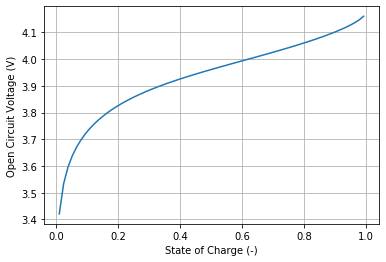

In [24]:
plt.figure()
plt.plot(SOC,OCVfromSOC)
plt.grid()
plt.xlabel('State of Charge (-)')
plt.ylabel('Open Circuit Voltage (V)')

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Text(0, 0.5, 'State of Charge (-)')

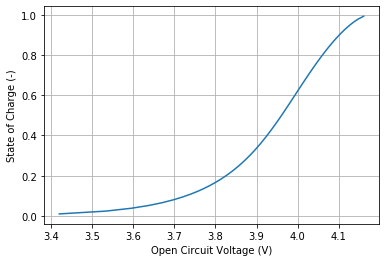

In [25]:
SOCfromOCV = interp1d(OCVfromSOC,SOC)
plt.figure()
plt.plot(OCVfromSOC,SOCfromOCV(OCVfromSOC))
plt.grid()
plt.xlabel('Open Circuit Voltage (V)')
plt.ylabel('State of Charge (-)')

In [26]:
SOC_cell = SOCfromOCV(cell_voltage)
print(cell_voltage)
print(SOC_cell)

[3.72928762 3.72996211 3.7429463  ... 3.58844928 3.58984037 3.59154497]
[0.10065313 0.10114176 0.11085868 ... 0.0364326  0.0367496  0.03713805]


Text(0, 0.5, 'State of Charge (-)')

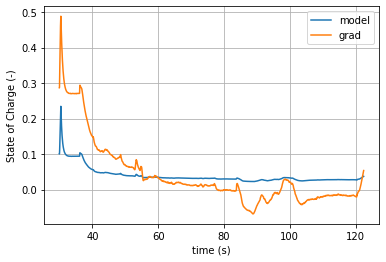

In [27]:
plt.figure()
plt.plot(time,SOC_cell,label='model')
plt.plot(time,remaining_voltage, label='grad')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

In [29]:
newremaining = []
newremaining.append(_remaining[0])

# the first discharge_mah_loop is now zero
for k in range(1,len(discharged_mah_loop)): #discharged_mah_loop has one less value than the others
    newremaining.append((1-weight_v[k]) * newremaining[k-1] + weight_v[k] * SOC_cell[k])
    newremaining[k] -= discharged_mah_loop[k] / capacity_tot
    newremaining[k] = np.max(newremaining[k],0)

Text(0, 0.5, 'State of Charge (-)')

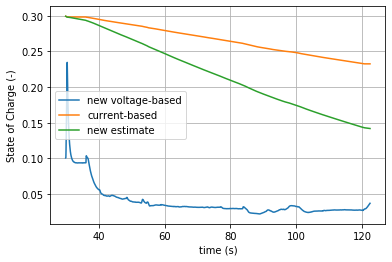

In [30]:
plt.figure()
plt.plot(time,SOC_cell,label='new voltage-based')
plt.plot(time,remaining_current,label='current-based')
plt.plot(time,newremaining,label='new estimate')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

Text(0, 0.5, 'State of Charge (-)')

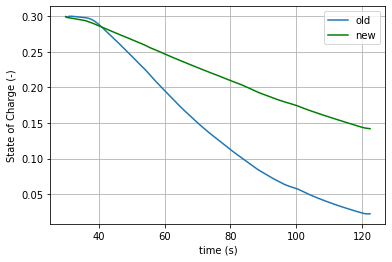

In [35]:
plt.figure()
plt.plot(time,_remaining,label="old")
plt.plot(time,newremaining,color='green',label="new")
plt.legend()
plt.grid()
plt.xlabel("time (s)")
plt.ylabel('State of Charge (-)')